In [91]:
import deeplay as dl
import numpy as np
from deeplay.applications.detection.lodestar.transforms import *
import numpy as np
import torch
from generator import generate_canada
import matplotlib.pyplot as plt

**Generated training data at different z-positions vs experimental data**<br>
Particle size = 45nm - 55nm<br>
Particle resolution = 65 nm  

(-0.5, 366.5, 367.5, -0.5)

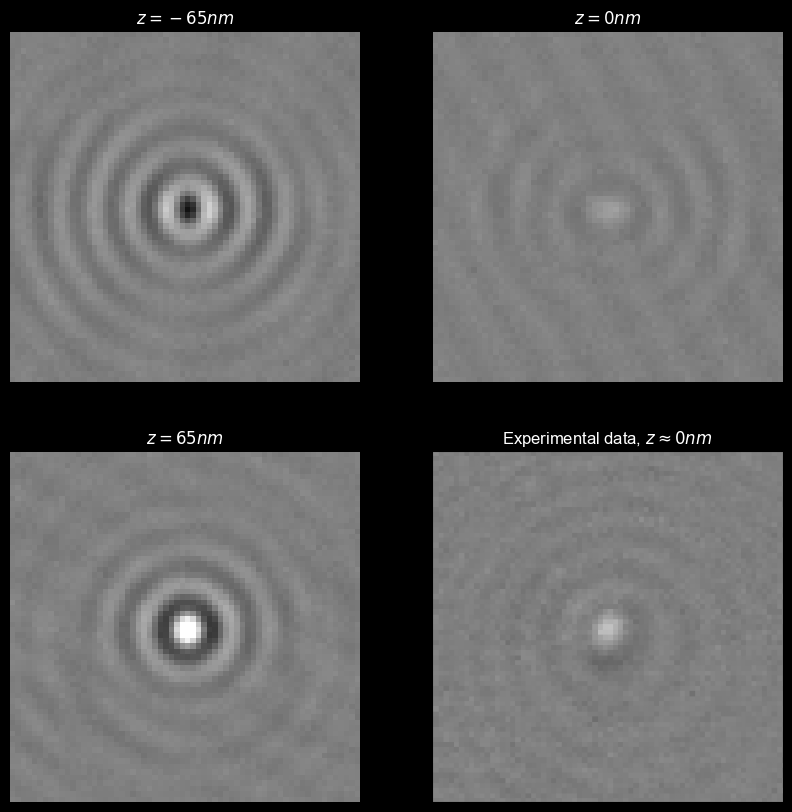

In [93]:
image_size = 64

plt.style.use('dark_background')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].imshow(generate_canada(image_size, z = -1), cmap='gray', vmin=-1.5, vmax=1.5)
axs[0,0].set_title(r'$z = -65 nm$')
axs[0,0].axis('off')

axs[0,1].imshow(generate_canada(image_size, z = 0), cmap='gray', vmin=-1.5, vmax=1.5)
axs[0,1].set_title(r'$z = 0 nm$')
axs[0,1].axis('off')

axs[1,0].imshow(generate_canada(image_size, z = 1), cmap='gray', vmin=-1.5, vmax=1.5)
axs[1,0].set_title(r'$z = 65 nm$')
axs[1,0].axis('off')

#load experimental data
image = plt.imread('partikel.png')

axs[1,1].imshow(image, cmap='gray')
axs[1,1].set_title(r'Experimental data, $z \approx 0 nm$')
axs[1,1].axis('off')


**Additional transformations that are added to the LodeSTAR method:**

In [94]:
from deeplay.applications.detection.lodestar.transforms import Transform

class RandomTranslationZ(Transform):
    def __init__(self, dz=lambda: np.random.uniform(-3, 3)):
        indices = (2,)
        super().__init__(self._forward, self._backward, dz=dz, indices=indices)

    @staticmethod 
    def _forward(x, dz, indices):

        radius = lambda: np.random.uniform(45e-9, 55e-9)
        polarization_angle = lambda: np.random.rand() * 2 * np.pi
        ph= 1/16*np.pi

        transformed = torch.empty_like(x)

        for i, dz_one in enumerate(dz):
            image = generate_canada(image_size, z = float(dz_one), 
                                    radius=radius, 
                                    polarization_angle=polarization_angle, 
                                    ph=ph)
            image = torch.tensor(image).permute(2, 0, 1)
            transformed[i] = image
            
        return transformed.to(x.device)
        
    @staticmethod
    def _backward(x, dz, indices):
        sub_v = torch.zeros_like(x)
        sub_v[:, indices[-1]] = dz
        return x - sub_v

class RandomScaleImage(Transform):
    def __init__(self, scale=lambda: np.random.uniform(0.8, 1.2)):
        super().__init__(self._forward, self._backward, scale=scale)

    @staticmethod
    def _forward(x, scale):
        return x * scale.view(-1, 1, 1, 1).to(x.device)

    @staticmethod
    def _backward(x, scale):
        return x

**Trainer class:**

In [98]:
class LodeSTAR3DTrainer:

    def __init__(self,
                 epochs=1000,
                 batch_size=10,
                 num_transforms=8,
                 learning_rate= 1e-4,
                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                 model=None
                 ):
    
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_transforms = num_transforms
        self.learning_rate = learning_rate
        self.device = device
        self.model = model.to(self.device)
        self.num_outputs = 3
        self.losses = []

        self.lodestar = dl.LodeSTAR(model = self.model,
                                    num_outputs = self.num_outputs,
                                    n_transforms = self.num_transforms,
                                    transforms = Transforms([
                                                            RandomTranslationZ(),
                                                            RandomTranslation2d(),
                                                            RandomRotation2d(),
                                                            RandomScaleImage(),
                                                            ]))
        self.model = self.lodestar._get_default_model() if model == None else model
    
    def train(self, image_size = 64, lower_loss_bound = None):
        print(f"Using device: {self.device}")
        self.losses = []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        dataloader = torch.utils.data.DataLoader(dataset = 
                                                 torch.empty((self.batch_size, image_size, image_size)).to(self.device))

        for epoch in range(1, self.epochs+1):

            for sample in dataloader:
                transforms, inverses = self.lodestar.transform_data(sample)
                prediction = self.lodestar.forward(transforms)
                loss_dict = self.lodestar.compute_loss(prediction, inverses)
                loss1, loss2 = loss_dict['between_image_disagreement'], loss_dict['within_image_disagreement']
                loss = loss1 + loss2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                self.losses.append(loss.item())

            if lower_loss_bound != None:
                if self.losses[epoch] < lower_loss_bound and self.losses[epoch-1] < lower_loss_bound:
                    print(f"Lower loss bound of {lower_loss_bound} reached. Stopping training.")
                    break
        
            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs} \tLoss: {self.losses[-1]}", end='\r')
        
    def plot_losses(self, yscale='linear'):
        plt.scatter([i for i in list(range(1, len(self.losses)+1))], self.losses, s=1, color='black')
        plt.grid()
        plt.yscale(yscale)
        plt.show()

TypeError: LodeSTAR._get_default_model() missing 1 required positional argument: 'self'

In [97]:
from model import CNN # Standard CNN used for the LodeSTAR model

trainer = LodeSTAR3DTrainer(model = CNN(),
                            batch_size=10,
                            epochs = 1000,)

trainer.train(lower_loss_bound=0.8) 
# Lower loss bound is set to 0.5 to speed up the training process for the sake of this example

Using device: cuda


RuntimeError: The expanded size of the tensor (1) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [1, -1, -1].  Tensor sizes: [8, 2, 3]